![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# DMD with unitary linear operator

## Theory

[P. Baiddoo et al.](https://github.com/baddoo/piDMD) introduced several physically motived constraints for the DMD operator (the so-called physics-informed DMD). One particularly useful constraint is the unitary construction of the DMD operator $\mathbf{A}$ (refer to [this notebook](dmd_intro.ipynb) regarding the DMD basics). Unitary transformations are norm-preserving in the sense that:
$$
  ||\mathbf{Ax}||_2 = ||\mathbf{x}||_2\quad \text{given that}\quad \mathbf{A}^\ast\mathbf{A} = \mathbf{AA}^\ast = \mathbf{I}.
$$
Let's that the state vector $\mathbf{x}_n$ contains the velocity components of a flow field at time instance $n$. Then the inner product $\langle\mathbf{x}_n,\mathbf{x}_n\rangle$ yields twice the flow's kinetic energy in the considered domain at time instance $n$:
$$
  2K = \langle\mathbf{x}_n,\mathbf{x}_n\rangle = ||\mathbf{x}_n||_2^2.
$$
If $\mathbf{A}$ is unitary and advances $\mathbf{x}_n$ to $\mathbf{x}_{n+1}$, then we know that the kinetic energy is conserved in a global (control volume) sense.

The solution to the [orthogonal Procrustus problem](https://link.springer.com/content/pdf/10.1007/BF02289451.pdf) tells us how to find $\mathbf{A}$ in the least-squares sense:
$$
  \underset{\mathbf{A}^\ast\mathbf{A}=\mathbf{I}}{\mathrm{argmin}}||\mathbf{X}^\prime - \mathbf{AX}||_2.
$$
Given the matrix $\mathbf{S} = \mathbf{X}^\prime\mathbf{X}^\ast$ and its SVD $\mathbf{S} = \mathbf{U}_s\mathbf{\Sigma}_s \mathbf{V}_s^\ast$, the optimal unitary linear operator is:
$$
  \mathbf{A} = \mathbf{U}_s\mathbf{V}_s^\ast.
$$
When computing the DMD of large state vectors, it is more practical to project both $\mathbf{X}$ and $\mathbf{X}^\prime$ onto the first $r$ left singular vectors of $\mathbf{X}$ before computing $\mathbf{S}$. Given the truncated SVD $\mathbf{X}\approx \mathbf{U}_r\mathbf{\Sigma}_r\mathbf{V}_r^\ast$, the projected data matrices are computed as:
$$
  \tilde{\mathbf{X}} = \mathbf{U}_r^\ast \mathbf{X} \quad\text{and}\quad \tilde{\mathbf{X}}^\prime = \mathbf{U}_r^\ast \mathbf{X}^\prime .
$$

## Examples
### Flow past a circular cylinder

Similar to the example presented in [P. Baiddoo et al.](https://github.com/baddoo/piDMD), we use snapshots from the flow past a cylinder at $Re=100$ (refer to the [SVD example](svd_cylinder.ipynb) for the setup), contaminate the snapshots with some noise, and perform DMD with and without the unitary contraint. However, before looking at the DMD, we inspect the norm of differently composed state vector to see if the states' norm is actually preserved.

#### Norm of state vectors

First, we load snapshots of vorticity and velocity in the quasi-steady flow regime, add noise to the snapshots, and assemble different state vectors.

In [98]:
import torch as pt
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from flowtorch import DATASETS
from flowtorch.data import FOAMDataloader, CSVDataloader, mask_box
from flowtorch.analysis import DMD

# increase resolution of plots
plt.rcParams['figure.dpi'] = 160

In [2]:
path = DATASETS["of_cylinder2D_binary"]
loader = FOAMDataloader(DATASETS["of_cylinder2D_binary"])
window_times = [time for time in loader.write_times if float(time) >= 6.0]
times_num = pt.tensor([float(time) for time in window_times])

In [3]:
vertices = loader.vertices
weights = loader.weights
U, vort = loader.load_snapshot(["U", "vorticity"], window_times)
vort = vort[:, 2, :]

Could not find precomputed cell centers and volumes.
Computing cell geometry from scratch (slow, not recommended for large meshes).
To compute cell centers and volumes in OpenFOAM, run:

postProcess -func "writeCellCentres" -constant -time none
postProcess -func "writeCellVolumes" -constant -time none


In [4]:
def add_noise_to_data(data: pt.Tensor, level: float) -> pt.Tensor:
    if len(data.shape) > 2:
        noisy_data = pt.zeros_like(data)
        shape = (data.shape[0], data.shape[-1])
        for i in range(data.shape[1]):
            val_range = (data[:, i, :].max() - data[:, i, :].min()) * level
            noisy_data[:, i, :] = data[:, i, :] + val_range * 2 * (pt.rand(shape) - 0.5)
        return noisy_data
    else:
        val_range = (data.max() - data.min()) * level
        return data + val_range * 2 * (pt.rand(data.shape) - 0.5)

In [5]:
vort_noisy = add_noise_to_data(vort, 0.02)
U_noisy = add_noise_to_data(U, 0.1)

In [6]:
x = vertices[:, 0]
y = vertices[:, 1]

def add_field(ax, field, title, every=4):
    ax.tricontourf(x[::every], y[::every], field[::every], levels=15, cmap="jet")
    ax.tricontour(x[::every], y[::every], field[::every], levels=15, linewidths=0.1, colors='k')
    ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='k'))
    ax.set_aspect("equal", 'box')
    ax.set_title(title)

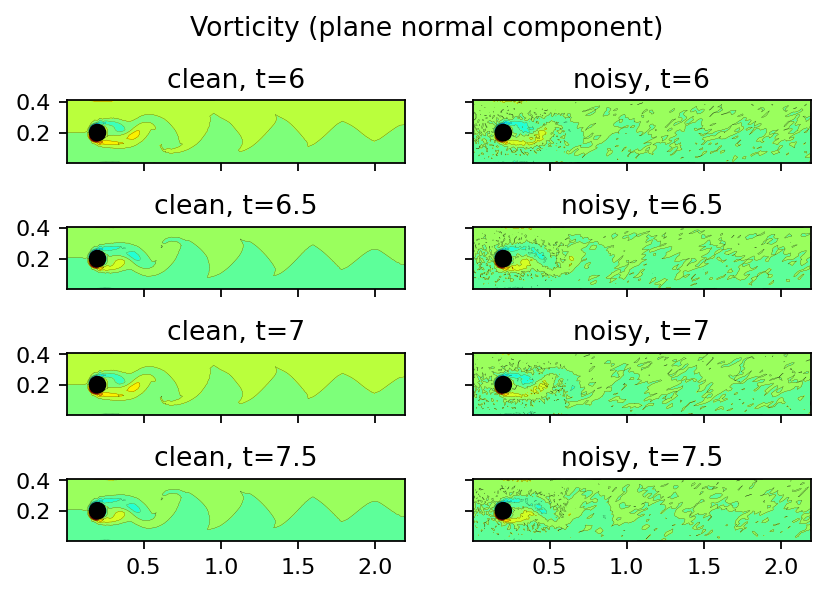

In [7]:
fig, axarr = plt.subplots(4, 2, figsize=(6, 4), sharex=True, sharey=True)
count = 0
for row in range(4):
    add_field(axarr[row, 0], vort[:, count], f"clean, t={window_times[count]}")
    add_field(axarr[row, 1], vort_noisy[:, count], f"noisy, t={window_times[count]}")
    count += 20
    
fig.suptitle("Vorticity (plane normal component)")
plt.show()

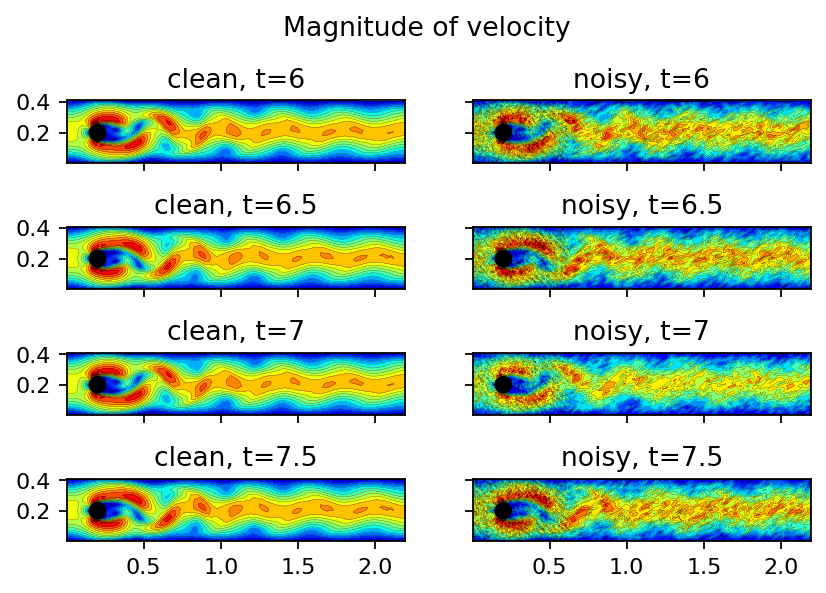

In [8]:
fig, axarr = plt.subplots(4, 2, figsize=(6, 4), sharex=True, sharey=True)
count = 0
for row in range(4):
    add_field(axarr[row, 0], pt.linalg.norm(U, dim=1)[:, count], f"clean, t={window_times[count]}")
    add_field(axarr[row, 1], pt.linalg.norm(U_noisy, dim=1)[:, count], f"noisy, t={window_times[count]}")
    count += 20
    
fig.suptitle("Magnitude of velocity")
plt.show()

Next, we inspect how the following factors influence the state vectors' norm:

- different fields, namely vorticity and velocity
- weighting of the state with the cell volume
- masking of the snapshots

In [9]:
x_max = pt.arange(0.3, vertices[:, 0].max(), 0.05)
vort_norm, vort_norm_weighted = [], []
vort_norm_noisy, vort_norm_weighted_noisy = [], []
U_norm, U_norm_weighted = [], []
U_norm_noisy, U_norm_weighted_noisy = [], []

for xm in x_max:
    mask = mask_box(vertices, [-1.0, -1.0, -1.0], [xm, 1.0, 1.0])
    n_points = mask.sum().item()
    vort_m = pt.zeros((n_points, len(window_times)))
    vort_m_noisy = pt.zeros((n_points, len(window_times)))
    U_m = pt.zeros((2*n_points, len(window_times)))
    U_m_noisy = pt.zeros((2*n_points, len(window_times)))
    for i in range(len(window_times)):
        vort_m[:, i] = pt.masked_select(vort[:, i], mask)
        vort_m_noisy[:, i] = pt.masked_select(vort_noisy[:, i], mask)
        U_m[:n_points, i] = pt.masked_select(U[:, 0, i], mask)
        U_m[n_points:, i] = pt.masked_select(U[:, 1, i], mask)
        U_m_noisy[:n_points, i] = pt.masked_select(U_noisy[:, 0, i], mask)
        U_m_noisy[n_points:, i] = pt.masked_select(U_noisy[:, 1, i], mask)
    weights_m = pt.masked_select(weights, mask).unsqueeze(-1)
    vort_norm.append(pt.linalg.norm(vort_m, dim=0))
    vort_norm_weighted.append(pt.linalg.norm(vort_m*weights_m, dim=0))
    vort_norm_noisy.append(pt.linalg.norm(vort_m_noisy, dim=0))
    vort_norm_weighted_noisy.append(pt.linalg.norm(vort_m_noisy*weights_m, dim=0))
    U_norm.append(pt.linalg.norm(U_m, dim=0))
    U_norm_weighted.append(pt.linalg.norm(U_m*pt.vstack((weights_m, weights_m)), dim=0))
    U_norm_noisy.append(pt.linalg.norm(U_m_noisy, dim=0))
    U_norm_weighted_noisy.append(pt.linalg.norm(U_m_noisy*pt.vstack((weights_m, weights_m)), dim=0))

In the next two plots below, we visualize the temporal standard deviation of the state vectors' spatial norm in a region of interest. First, the spatial norm of all state vectors is computed. This computation results in one norm (one scalar value) for snapshot. Then the norm's temporal standard deviation is computed, which yields one scalar value for each data matrix. This process is repeated for several regions of interest, which are defined based on $x_{max}$. The variable $x_{max}$ defines the extend of the selected part of the snapshot (all points with $x < x_{max}$ are selected). Finally, the temporal standard deviation is normalized with the temporal mean to make the analysis of different state vectors comparable.

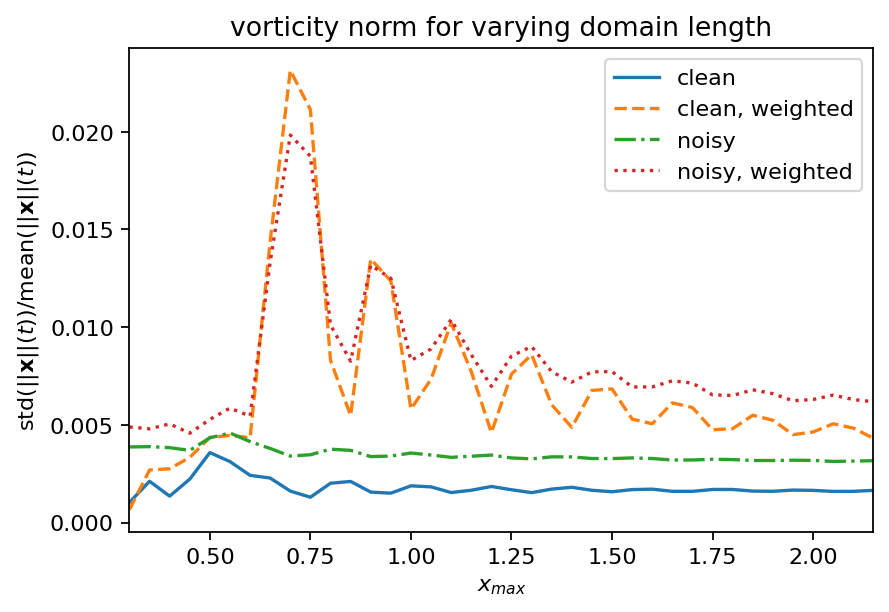

In [10]:
labels = ("clean", "clean, weighted", "noisy", "noisy, weighted")
ls = ("-", "--", "-.", ":")
for i, state in enumerate((vort_norm, vort_norm_weighted, vort_norm_noisy, vort_norm_weighted_noisy)):
    plt.plot(x_max, [s.std()/s.mean() for s in state], ls=ls[i], label=labels[i])
plt.xlabel(r"$x_{max}$")
plt.xlim(x_max[0], x_max[-1])
plt.ylabel(r"$\mathrm{std}(||\mathbf{x}||(t)) / \mathrm{mean}(||\mathbf{x}||(t))$")
plt.legend()
plt.title("vorticity norm for varying domain length")
plt.show()

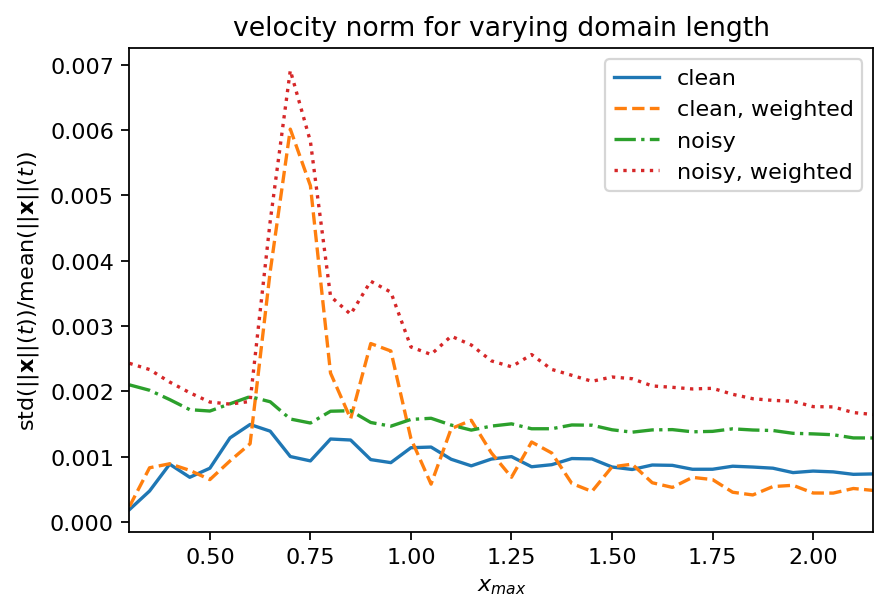

In [11]:
for i, state in enumerate((U_norm, U_norm_weighted, U_norm_noisy, U_norm_weighted_noisy)):
    plt.plot(x_max, [s.std()/s.mean() for s in state], ls=ls[i], label=labels[i])
plt.xlabel(r"$x_{max}$")
plt.xlim(x_max[0], x_max[-1])
plt.ylabel(r"$\mathrm{std}(||\mathbf{x}||(t)) / \mathrm{mean}(||\mathbf{x}||(t))$")
plt.legend()
plt.title("velocity norm for varying domain length")
plt.show()

For all tested state vectors, the relative change of the state vectors' norm is well below $1\%$. We can now take a closer look on how the norm changes over time. Again, it is sensible to normalize the spatial norm with its temoral mean value to make the norms of different state vectors comparable.

x_max=1.30


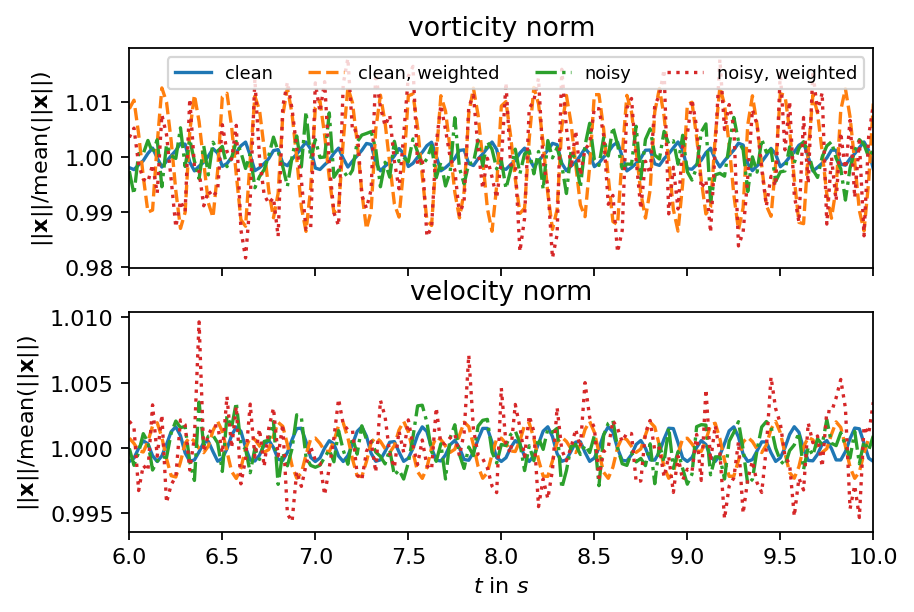

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

ind = 20
for i, state in enumerate((vort_norm, vort_norm_weighted, vort_norm_noisy, vort_norm_weighted_noisy)):
    ax1.plot(times_num, state[ind] / state[ind].mean(), ls=ls[i], label=labels[i])
    
for i, state in enumerate((U_norm, U_norm_weighted, U_norm_noisy, U_norm_weighted_noisy)):
    ax2.plot(times_num, state[ind] / state[ind].mean(), ls=ls[i])
    
print(f"x_max={x_max[ind].item():2.2f}")
ax1.legend(ncol=len(labels), fontsize=8)
ax1.set_ylabel(r"$||\mathbf{x}||/\mathrm{mean}(||\mathbf{x}||)$")
ax1.set_title("vorticity norm")
ax2.set_ylabel(r"$||\mathbf{x}||/\mathrm{mean}(||\mathbf{x}||)$")
ax2.set_title("velocity norm")
ax2.set_xlim(times_num[0], times_num[-1])
ax2.set_xlabel(r"$t$ in $s$")
plt.show()

Based on the plot above, the following observations may be made:

- weighting the state vector with the cell volume yields a small increase in the norm's variability over time; however, the change is below $2\%$ and $0.6\%$ relative to the temporal mean for vorticity and velocity, respectively
- additional noise in the data increases the changes in the norm; nonetheless, this change is not significant for the cylinder data

#### DMD variants and options

In this section, we investigate the influence of the orthogonality contraint on the DMD analysis. The region of interested is slected such that $0.0 \leq x \leq 1.0$. Only the vorticity field is investigated further. First, the reconstruction error is computed for the following combinations of data and settings:

- SVD ranks between 2 and 20
- clean and noisy data
- standard DMD
- standard DMD with optimal mode amplitudes
- DMD with orthogonality constraint
- DMD with orthogonality constraint and optimal mode amplitudes

Note that for the noisy data, the error is computed by comparing the reconstruction to the **clean data**.

In [13]:
mask = mask_box(vertices, [0.0, -1.0, -1.0], [1.0, 1.0, 1.0])
n_points = mask.sum().item()
dm = pt.zeros((n_points, len(window_times)))
dm_noisy = pt.zeros_like(dm)

for i in range(len(window_times)):
    dm[:, i] = pt.masked_select(vort[:, i], mask)
    dm_noisy[:, i] = pt.masked_select(vort_noisy[:, i], mask)

In [14]:
err, err_noisy = [], []
err_opt, err_noisy_opt = [], []
err_orth, err_noisy_orth = [], []
err_opt_orth, err_noisy_opt_orth = [], []

dt = times_num[1] - times_num[0]

for rank in range(2, 21):
    err.append(pt.norm(DMD(dm, dt, rank=rank).reconstruction - dm))
    err_noisy.append(pt.norm(DMD(dm_noisy, dt, rank=rank).reconstruction - dm))
    err_opt.append(pt.norm(DMD(dm, dt, rank=rank, optimal=True).reconstruction - dm))
    err_noisy_opt.append(pt.norm(DMD(dm_noisy, dt, rank=rank, optimal=True).reconstruction - dm))
    err_orth.append(pt.norm(DMD(dm, dt, rank=rank, unitary=True).reconstruction - dm))
    err_noisy_orth.append(pt.norm(DMD(dm_noisy, dt, rank=rank, unitary=True).reconstruction - dm))
    err_opt_orth.append(pt.norm(DMD(dm, dt, rank=rank, unitary=True, optimal=True).reconstruction - dm))
    err_noisy_opt_orth.append(pt.norm(DMD(dm_noisy, dt, rank=rank, unitary=True, optimal=True).reconstruction - dm))

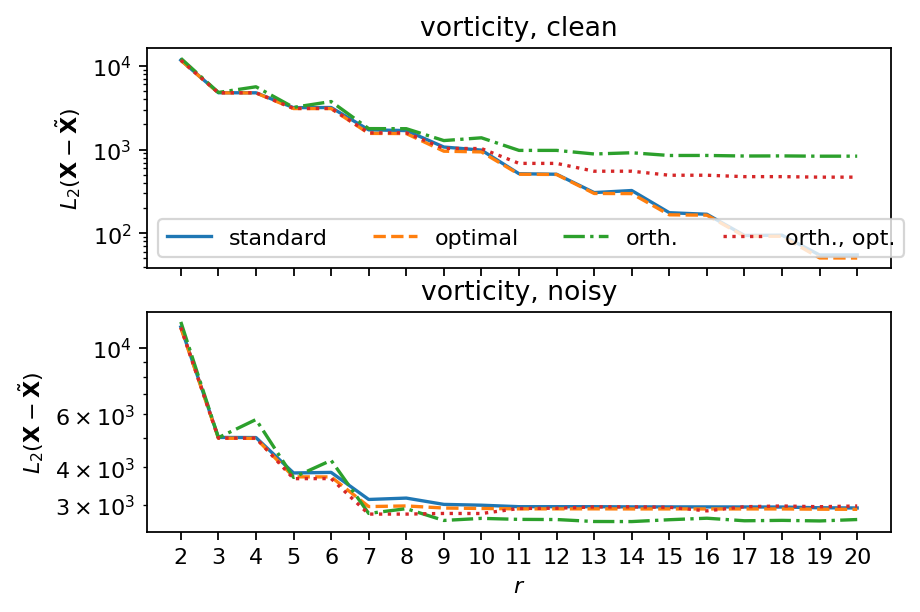

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

labels = ("standard", "optimal", "orth.", "orth., opt.")
ls = ["-", "--", "-.", ":"]

for i, err in enumerate((err, err_opt, err_orth, err_opt_orth)):
    ax1.plot(range(2, 21), err, ls=ls[i], label=labels[i])
for i, err in enumerate((err_noisy, err_noisy_opt, err_noisy_orth, err_noisy_opt_orth)):
    ax2.plot(range(2, 21), err, ls=ls[i])

ax1.legend(ncol=4)
ax1.set_title("vorticity, clean")
ax2.set_title("vorticity, noisy")
ax2.set_xlabel(r"$r$")
ax2.set_xticks(range(2, 21))
for ax in (ax1, ax2):
    ax.set_ylabel(r"$L_2(\mathbf{X}-\tilde{\mathbf{X}})$")
    ax.set_yscale("log")
plt.show()

A few observations in the plot above:

- for clean data, the orthogonality constraint limits the absolute accuracy compared to the standard DMD; this effect might be caused by some transient behavior in the snapshot data, which can not be captured if the linear operator is unitary (the magnitude of all eigenvalues is always one).
- for the clean data, the optimal mode amplitudes yield a lower reconstruction error in both cases
- for the noisy data, the DMD with orthogonality constraint yields the lowest reconstruction error over a wide range of ranks; note that the optimal amplitudes are computed based on the noisy data while the reconstruction error is computed against the clean data; therefore, the optimal amplitudes can display a higher reconstruction error

#### Influence of the noise level

In this section, we push the noise level in the data to an extreme and observe the influence of the orthogonality constraint.

In [16]:
err, err_opt = [], []
err_orth, err_opt_orth = [], []

n_points = mask.sum().item()
vort_m = pt.zeros((n_points, len(window_times)))
for i in range(len(window_times)):
    vort_m[:, i] = pt.masked_select(vort[:, i], mask)
    
levels = pt.arange(0.0, 0.2001, 0.01)
for level in levels:
    vort_noisy = add_noise_to_data(vort_m, level)
    err.append(pt.norm(DMD(vort_noisy, dt, rank=15).reconstruction - vort_m))
    err_opt.append(pt.norm(DMD(vort_noisy, dt, rank=15, optimal=True).reconstruction - vort_m))
    err_orth.append(pt.norm(DMD(vort_noisy, dt, rank=15, unitary=True).reconstruction - vort_m))
    err_opt_orth.append(pt.norm(DMD(vort_noisy, dt, rank=15, unitary=True, optimal=True).reconstruction - vort_m))

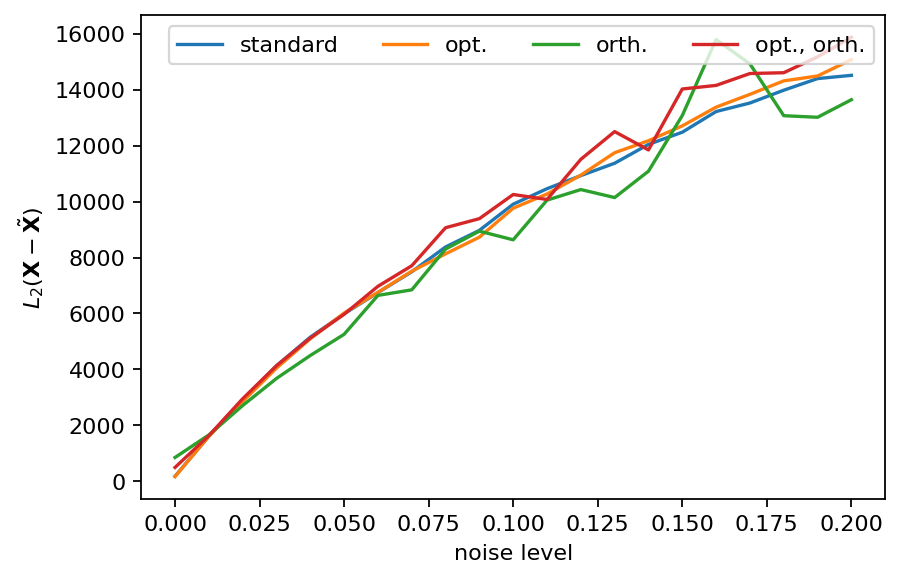

In [17]:
labels = ("standard", "opt.", "orth.", "opt., orth.")
for i, e in enumerate((err, err_opt, err_orth, err_opt_orth)):
    plt.plot(levels, e, label=labels[i])
    
plt.xlabel("noise level")
plt.ylabel(r"$L_2(\mathbf{X}-\tilde{\mathbf{X}})$")
plt.legend(ncol=4)
plt.show()